In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from dance_evaluation import *
import matplotlib.pyplot as plt

In [ ]:
def calculate_metrics_with_oe(ref, calculated, tolerance=10):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (np.ndarray): Estimated BPMs.
        tolerance (float): Precision window (default 4%).
    Returns:
        dict: Dictionary with Acc1, Acc2, Metric3, OE1, and OE2 values.
    """
    # ref_tolerance = ref * tolerance
    ref_tolerance = tolerance
    # Acc1: Within 4% of reference BPM
    acc1_count = np.sum(np.abs(calculated - ref) <= ref_tolerance)
    
    # Acc2: Within 4% of reference BPM, double, or half
    acc2_count = np.sum(
        (np.abs(calculated - ref) <= ref_tolerance) |
        (np.abs(calculated - 2 * ref) <= ref_tolerance) |
        (np.abs(calculated - ref / 2) <= ref_tolerance)
    )
    
    # Metric3: Within 4% of 1x, 2x, 1/2x, 3x, 1/3x, 4x, 1/4x, 6x
    scales = [1, 2, 0.5, 3, 1/3, 4, 1/4, 6]         #  [1, 2, 0.5, 3, 1/3, 4, 1/4, 6]
    metric3_count = 0
    for scale in scales:
        metric3_count += np.sum(np.abs(calculated - ref * scale) <= ref_tolerance)
    
    # OE1: Overestimated BPM outside hierarchical relationships
    oe1_count = np.sum(
        (calculated > ref) &  # Overestimation
        ~np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Not within any scale
    )
    
    # OE2: Overestimated BPM within hierarchical relationships
    oe2_count = np.sum(
        (calculated > ref) &  # Overestimation
        np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Within any scale
    )
    
    total = len(ref)
    
    metrics = {
        "Acc1": (acc1_count / total) * 100,
        "Acc2": (acc2_count / total) * 100,
        "Metric3": (metric3_count / total) * 100,
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
    }
    return metrics


### Both Foot Onsets

In [3]:
base = "hand"
sname = "hand"

df_p1 = pd.read_csv(f"./{base}/max_xyz/{sname}_maxxyz_p1_50_150.csv")
df_p2 = pd.read_csv(f"./{base}/max_xyz/{sname}_maxxyz_p2_50_150.csv")
df_z1 = pd.read_csv(f"./{base}/max_xyz/{sname}_maxxyz_zero_bi_50_150.csv")
df_z2 = pd.read_csv(f"./{base}/max_xyz/{sname}_maxxyz_zero_uni_50_150.csv")


ref = df_p1["bpm"].to_numpy()
p1_tempoA = df_p1["tempoA"].to_numpy()
p1_tempoB = df_p1["tempoB"].to_numpy()
p1_tempoC = df_p1["tempoC"].to_numpy()

p2_tempoA = df_p2["tempoA"].to_numpy()
p2_tempoB = df_p2["tempoB"].to_numpy()
p2_tempoC = df_p2["tempoC"].to_numpy()

z1_tempoA = df_z1["tempoA"].to_numpy()
z1_tempoB = df_z1["tempoB"].to_numpy()
z1_tempoC = df_z1["tempoC"].to_numpy()

z2_tempoA = df_z2["tempoA"].to_numpy()
z2_tempoB = df_z2["tempoB"].to_numpy()
z2_tempoC = df_z2["tempoC"].to_numpy()

# Calculate metrics for Z-axis
# metricsA = calculate_metrics_with_oe(ref, tempoA, tolerance=8)
# metricsB = calculate_metrics_with_oe(ref, tempoB, tolerance=8)
# metricsC = calculate_metrics_with_oe(ref, tempoC, tolerance=8)

# metrics_list = [metricsA, metricsB, metricsC]

In [4]:
# Data for each experiment
experiments = {
    "zero_uni": [z1_tempoA, z1_tempoB, z1_tempoC],
    "zero_bi": [z2_tempoA, z2_tempoB, z2_tempoC],
    "peak_uni": [p1_tempoA, p1_tempoB, p1_tempoC],  # Replace ref for XYZ if not available
    "peak_bi": [p2_tempoA, p2_tempoB, p2_tempoC]   # Replace ref for XYZ if not available
}

method_labels = ["Method-1", "Method-2", "Method-3"]
results = {"experiment": [], "method": [], "acc1": [], "acc2": []}

tolerance = 8
for exp_name, data in experiments.items():
    for axis_name, calculated in zip(method_labels, data):
        metrics = calculate_metrics_with_oe(ref, calculated, tolerance = tolerance)
        
        results["experiment"].append(exp_name)
        results["method"].append(axis_name)
        results["acc1"].append(metrics["acc1"])
        results["acc2"].append(metrics["acc2"])

results_df = pd.DataFrame(results)

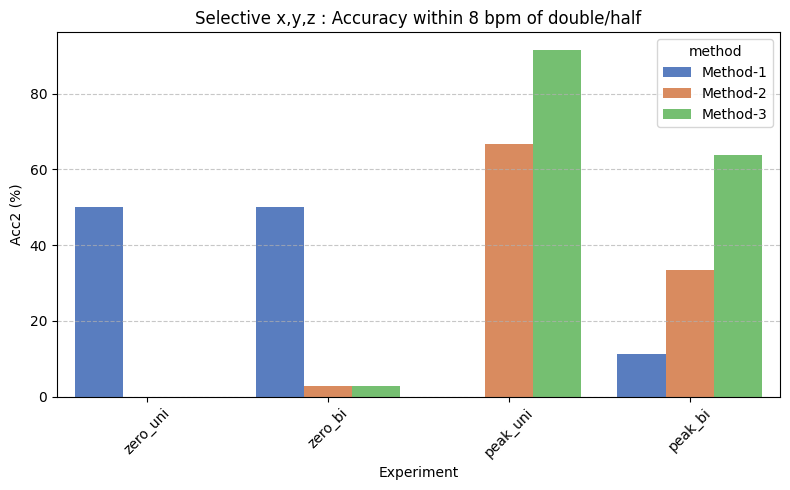

In [7]:

plt.figure(figsize=(8, 5))  # Adjust figure size for better readability
sns.barplot(data=results_df, x="experiment", y="acc2", palette="muted", hue="method")


plt.xlabel("Experiment")
plt.ylabel("Acc2 (%)")
plt.title(f"Selective x,y,z : Accuracy within {tolerance} bpm of double/half")
plt.xticks(rotation=45)  # Rotate labels if necessary
# plt.ylim(0, 100)  # Set consistent y-axis limits
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.tight_layout()
plt.savefig(f'./{base}/plots/{sname}_maxxyz_acc2.png')
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(tempoA/ref, bins=40)

plt.xlabel("Ratio")
plt.ylabel("Number of instance")
plt.title(f"Histograms of ratio between estimated tempo and correct tempo")
plt.show()